I decided, for my first post, to introduce and get familiar with the dataset that I plan to use for future learning and insight, which is basically all the offensive NFL statistics I could find. It’s a big enough dataset that you can potentially get insight from it, but not fully comprehensive of what a professional football game is as a whole. There are a few intentional decisions that I made when thinking about what I wanted out of this dataset.
1. I’m really only looking at specific offensive statistics and excluding kickoff return stats, for example.
2. Neglecting defensive statistics - I may decide to include these going forward, but I generally group these stats by position, and there are a lot of positions on defense.
3. I’m only tracking current players - the only benefit past player’s stats would give might be a coach’s specific tendencies, but I think those insights would be limited, at best.


In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib import request
import re
import os
import sqlite3
import matplotlib.pyplot as plt
% matplotlib inline

We first created a SQLite DB from web scraping, with different tables for each position. Initially, we're looking at just QB data and the initial stat correlations in order to determine relationships within the dataset.

In [2]:
query = 'SELECT * FROM qbs'
conn = sqlite3.connect('nfl_db.sqlite')
c = conn.cursor()
c.execute(query)
qb_df = pd.DataFrame(c.fetchall())
qb_df.columns = [desc[0] for desc in c.description]
qb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3784 entries, 0 to 3783
Data columns (total 15 columns):
date                  3784 non-null object
team                  3784 non-null object
opponent              3784 non-null object
result                3784 non-null object
attempts              3784 non-null int64
completions           3784 non-null int64
percent               3784 non-null float64
yards                 3784 non-null int64
yards_per_attempt     3784 non-null float64
touchdowns            3784 non-null int64
interceptions         3784 non-null int64
longest_completion    3784 non-null object
sacks                 3784 non-null object
qb_rating             3784 non-null float64
player_name           3784 non-null object
dtypes: float64(3), int64(5), object(7)
memory usage: 443.5+ KB


For variable analysis and correlation, columns should only be strings when absolutely necessary. From the DataFrame.info() method, we can see that the columns date, team, opponent, result, longest_completion, sacks, and player_name are of "object" datatype, which basically means that it is a numpy array with a variable storage capacity, meaning it is a string.  

While there are better ways of going about this, we will initially be manipulating these columns manually into workable variables through helper functions. First, we have to get a sense of why the columns are strings (only one row in the column can be a string for the whole column to be considered of "object" dataype, so it might require some searching.

In [3]:
qb_df.head()

,date,team,opponent,result,attempts,completions,percent,yards,yards_per_attempt,touchdowns,interceptions,longest_completion,sacks,qb_rating,player_name
0,08/11/16,Jax,@ NYJ,"L, 17-13",19,10,52.6,138,7.3,0,1,27,1/10,54.3,brandon allen
1,08/20/16,Jax,TB,"L, 27-21",3,0,0.0,0,0.0,0,1,0,0/0,0.0,brandon allen
2,09/01/16,Jax,@ Atl,"L, 17-15",26,17,65.4,164,6.3,2,1,25t,2/18,92.5,brandon allen
3,08/26/16,Car,NE,"L, 19-17",9,5,55.6,37,4.1,0,1,18,0/0,25.9,derek anderson
4,09/25/16,Car,Min,"L, 22-10",1,1,100.0,3,3.0,0,0,3,0/0,79.2,derek anderson


Luckily, we can see in the first 5 rows some of the issues: 

The date column is the date of the column, but stored as a string rather than datetime. It's preferable for dates to be in datetime in order to manipulate them as dates rather than just a random assortment of characters in a string. 

The result column is stored as a typical result column for the NFL, and will have to be split into useable variables (win/loss result, score, opponent's score). 

Longest completion has a 't' at the end of some numbers to indicate a tie between longest completed throws during that game. 

The sacks column can be split into number of sack and the length of the sacks.

Other than those columns, player_name, team, and opponent can stay as strings for our investigative purposes for the time being.

These are the helper functions that can be applied to the dataset in order to create a more standardized dataset for evaluating stat relationships:

In [4]:
def longest_fix(x):
    if isinstance(x, str):
        return int(x[:-1])
    return x

In [5]:
def month_fix(x):
    if x < 3:
        x = 12 + x
    return x - 7

In [6]:
def winloss_fix(x):
    return int(x.split(',')[0] == 'W')

In [7]:
def score_fix(x):
    win_loss = x.split(',')[0]
    if win_loss == 'W':
        return int(x.split(',')[1].split('-')[0])
    return int(x.split(',')[1].split('-')[1])

In [8]:
def sack_fix(series):
    sack_number_list = []
    sack_length_list = []
    for x in series.values:
        sack_number, sack_length = x.split('/')
        sack_number_list.append(int(sack_number))
        sack_length_list.append(int(sack_length))
    return pd.Series(sack_number_list), pd.Series(sack_length_list)

After defining the fixes previously described, we need to apply the functions to the dataset and either append them to the DataFrame, or replace the columns with the fixed columns:

In [9]:
qb_df['date'] = pd.to_datetime(qb_df.date, format="%m/%d/%y")
qb_df['score'] = qb_df.result.apply(lambda x: score_fix(x))
qb_df['win_loss'] = qb_df.result.apply(lambda x: winloss_fix(x))
qb_df['month'] = qb_df.date.apply(lambda x: month_fix(x.month))
qb_df['longest_completion'] = qb_df.longest_completion.apply(lambda x: longest_fix(x))
qb_df['times_sacked'], qb_df['sack_length'] = sack_fix(qb_df['sacks'])
qb_df = qb_df.drop(['sacks', 'result'], 1)

To check the results, we can look at the new resulting dataframe and the types of its columns:

In [10]:
qb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3784 entries, 0 to 3783
Data columns (total 18 columns):
date                  3784 non-null datetime64[ns]
team                  3784 non-null object
opponent              3784 non-null object
attempts              3784 non-null int64
completions           3784 non-null int64
percent               3784 non-null float64
yards                 3784 non-null int64
yards_per_attempt     3784 non-null float64
touchdowns            3784 non-null int64
interceptions         3784 non-null int64
longest_completion    3784 non-null int64
qb_rating             3784 non-null float64
player_name           3784 non-null object
score                 3784 non-null int64
win_loss              3784 non-null int64
month                 3784 non-null int64
times_sacked          3784 non-null int64
sack_length           3784 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(11), object(3)
memory usage: 532.2+ KB


As many of the stats within the dataset are encapsulated within the Quarterback Rating, it makes sense to use that to look at the matchups and locations that produce the highest and lowest QBRs. First, however, we'll have to normalize the QBRs by the average QBR of each quarterback to ascertain absolute performance.

In [11]:
average_qb_rating = []
for name in qb_df.player_name.values:
    average_qb_rating.append(qb_df[qb_df.player_name == name].qb_rating.mean())
qb_df['average_qb_rating'] = average_qb_rating
qb_df['norm_rating'] = qb_df.qb_rating/qb_df.average_qb_rating

To visualize the normalized QBR data, I chose to group the data by the team that the quarterback in question was playing against. This was done in order to determine the team that allows the highest and lowest QBR over the course of the last 10 years.

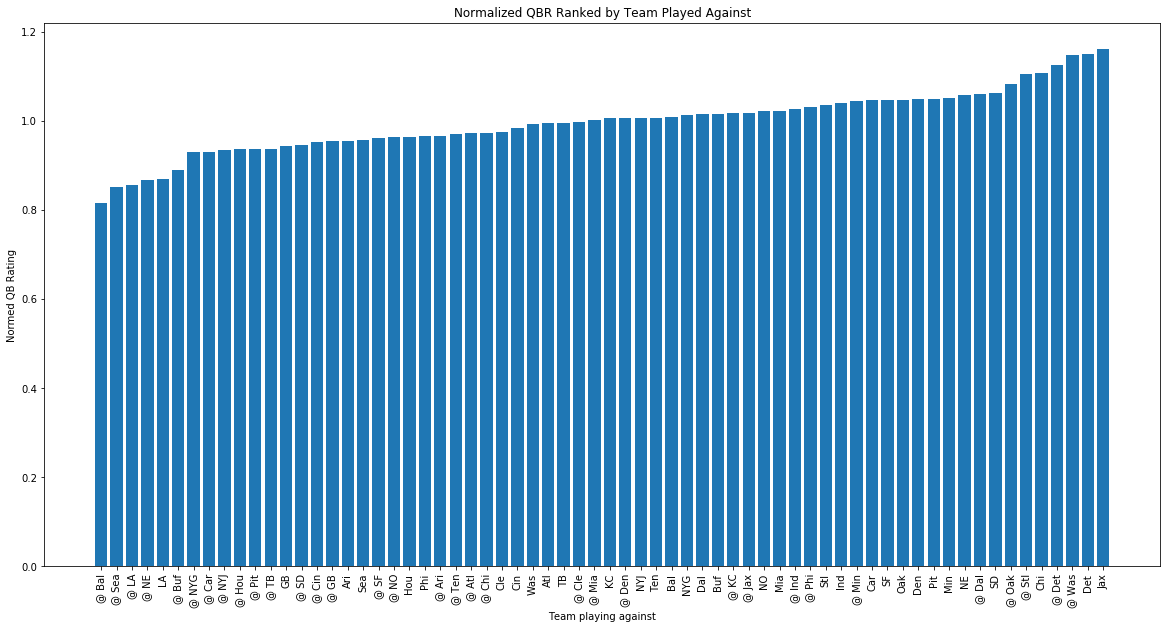

In [32]:
temp_df = qb_df.groupby('opponent').norm_rating.mean().sort_values()
plt.figure(figsize=(20,10))
plt.bar(range(66), temp_df.values)
plt.xticks(range(66), temp_df.index, rotation=90)
plt.ylabel('Normed QB Rating')
plt.xlabel('Team playing against')
plt.title('Normalized QBR Ranked by Team Played Against')
plt.show()

In order to determine other features to look at for analysis, a heatmap of the dataset allows us to look at the linear relationship between each pair of variables.

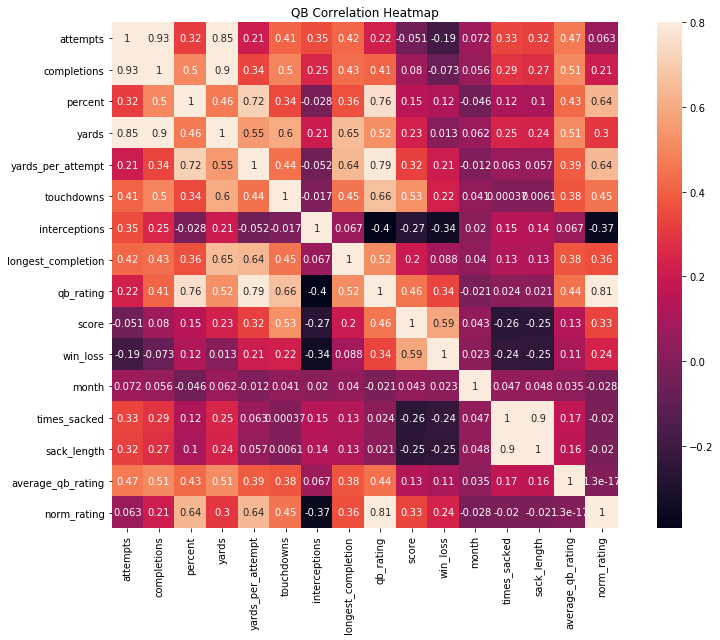

In [35]:
import seaborn as sns
corrmat = qb_df.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True)
plt.title('QB Correlation Heatmap')
plt.tight_layout()

Ultimately, I think the variable it makes the most sense to investigate as the independent variable is win_loss, as it's what the game is all about. The variables that have the highest linear correlation to winning are score (0.59), normalized QB rating (0.24), touchdowns (0.22), and yards per attempt (0.21). Unfortunately, these are all fairly weak correlations, which means a multivariate analysis might be appropriate for looking into what quarterbacks contribute to winning games.

Multivariate analysis is for another time though. At the moment we're going to look at the RB dataset.

In [14]:
query = 'SELECT * FROM rbs'
conn = sqlite3.connect('nfl_db.sqlite')
c = conn.cursor()
c.execute(query)
rb_df = pd.DataFrame(c.fetchall())
rb_df.columns = [desc[0] for desc in c.description]
rb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5777 entries, 0 to 5776
Data columns (total 20 columns):
date                           5777 non-null object
team                           5777 non-null object
opponent                       5777 non-null object
result                         5777 non-null object
rushing_attempts               5777 non-null float64
rushing_yards                  5777 non-null float64
rushing_yards_per_attempt      5777 non-null float64
rushing_long                   5777 non-null object
rushing_touchdowns             5777 non-null float64
rushing_first_downs            5777 non-null float64
receptions                     5777 non-null float64
receiving_yards                5777 non-null float64
average_yards_per_reception    5777 non-null float64
reception_long                 5777 non-null object
receiving_touchdowns           5777 non-null float64
receiving_first_downs          5777 non-null float64
targets                        5777 non-null object

As with the quarterbacks DB, there are plenty of useless columns in this dataset. We will clean them up similarly.

In [15]:
rb_df.head()

,date,team,opponent,result,rushing_attempts,rushing_yards,rushing_yards_per_attempt,rushing_long,rushing_touchdowns,rushing_first_downs,receptions,receiving_yards,average_yards_per_reception,reception_long,receiving_touchdowns,receiving_first_downs,targets,yards_after_catch,player_name,id
0,09/11/16,Det,@ Ind,"W, 39-35",12.0,63.0,5.25,13,0.0,3.0,5.0,57.0,11.4,18,1.0,4.0,5,54,ameer abdullah,1
1,09/18/16,Det,Ten,"L, 16-15",6.0,38.0,6.33,24,0.0,3.0,0.0,0.0,0.0,0,0.0,0.0,0,0,ameer abdullah,2
2,09/13/15,Det,@ SD,"L, 33-28",7.0,50.0,7.14,24t,1.0,2.0,4.0,44.0,11.0,36,0.0,2.0,4,58,ameer abdullah,3
3,09/20/15,Det,@ Min,"L, 26-16",6.0,9.0,1.50,7,0.0,0.0,1.0,9.0,9.0,9,0.0,0.0,1,6,ameer abdullah,4
4,09/27/15,Det,Den,"L, 24-12",8.0,23.0,2.88,9,0.0,1.0,2.0,19.0,9.5,16t,1.0,1.0,5,21,ameer abdullah,5


As the targets and yards_after_catch (yac) columns are not intuitive as to why they're objects, this helper function will list every unique string in the two columns.

In [16]:
str_list = []

In [17]:
def value_analysis(x):
    try:
        int(x)
    except:
        if x not in str_list:
            str_list.append(x)

In [18]:
rb_df['targets'].apply(lambda x: value_analysis(x))
rb_df['yards_after_catch'].apply(lambda x: value_analysis(x))
print(str_list)

['--']


A '--' string apparently is used for both columns for some reason, so just need to write an additional helper function to fix that, and the previously used helper methods can fix the rest of the dataframe.

In [19]:
def tar_yac_fix(x):
    if x == '--':
        return 0
    return int(x)

In [20]:
rb_df['date'] = pd.to_datetime(rb_df.date, format="%m/%d/%y")
rb_df['score'] = rb_df.result.apply(lambda x: score_fix(x))
rb_df['win_loss'] = rb_df.result.apply(lambda x: winloss_fix(x))
rb_df['month'] = rb_df.date.apply(lambda x: month_fix(x.month))
rb_df['rushing_long'] = rb_df.rushing_long.apply(lambda x: longest_fix(x))
rb_df['targets'] = rb_df['targets'].apply(lambda x: tar_yac_fix(x))
rb_df['yards_after_catch'] = rb_df['yards_after_catch'].apply(lambda x: tar_yac_fix(x))
rb_df = rb_df.drop(['id', 'result'], 1)

In [21]:
rb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5777 entries, 0 to 5776
Data columns (total 21 columns):
date                           5777 non-null datetime64[ns]
team                           5777 non-null object
opponent                       5777 non-null object
rushing_attempts               5777 non-null float64
rushing_yards                  5777 non-null float64
rushing_yards_per_attempt      5777 non-null float64
rushing_long                   5777 non-null float64
rushing_touchdowns             5777 non-null float64
rushing_first_downs            5777 non-null float64
receptions                     5777 non-null float64
receiving_yards                5777 non-null float64
average_yards_per_reception    5777 non-null float64
reception_long                 5777 non-null object
receiving_touchdowns           5777 non-null float64
receiving_first_downs          5777 non-null float64
targets                        5777 non-null int64
yards_after_catch              5777 non-nul

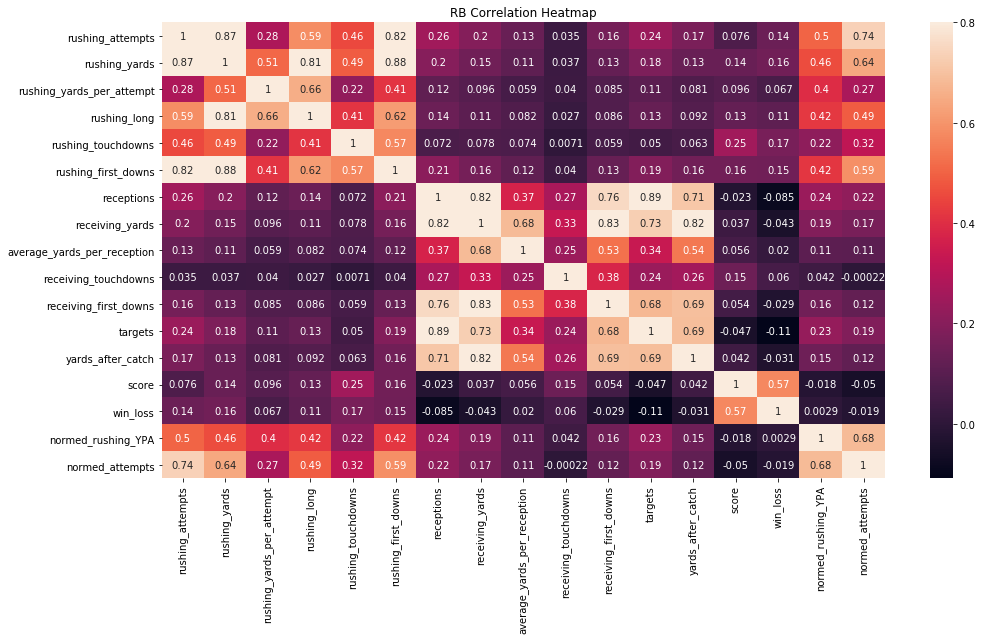

In [36]:
corrmat = rb_df.corr()
plt.figure(figsize=(15,9))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True)
plt.title('RB Correlation Heatmap')
plt.tight_layout()
plt.show()

Unfortunately, most of the findings from the heatmaps are unconsequential (i.e. number of targets highly correlated with number of receptions), so I thought it might be interesting to look into the change in RB stats over the course of the season instead.

In [23]:
def month_manip(x):
    if x == np.nan or x =='nan':
        return np.nan
    month_dict = {8.0:'August', 9.0:'September', 10.0:'October', 11.0:'November', 12.0:'December', 1.0:'January', 2.0:'February'}
    return month_dict[x]

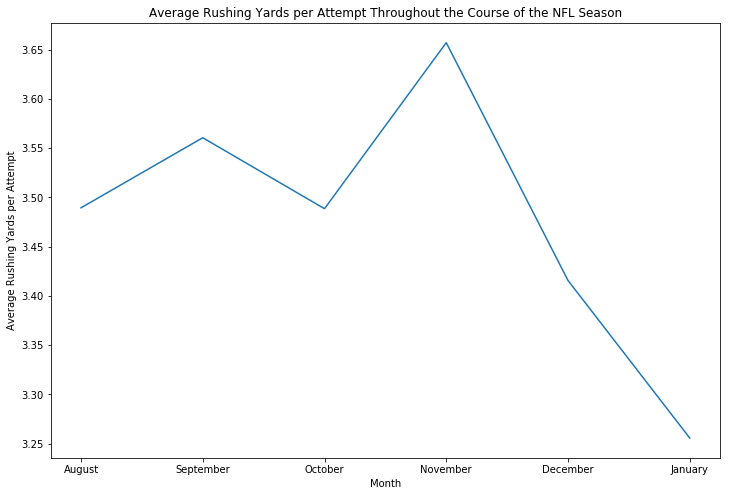

In [24]:
month = rb_df.date.apply(lambda x: x.month)
month = month.apply(lambda x: month_manip(x))
rb_df['month'] = month

month_names = ['August', 'September', 'October', 'November', 'December', 'January']
rypa = []
for m in rb_df.month.unique():
    if m != np.nan:
        rypa.append(rb_df.rushing_yards_per_attempt[rb_df.month == m].mean())

plt.figure(figsize=(12,8))
plt.plot(list(range(1,7)), rypa)
plt.xlabel('Month')
plt.ylabel('Average Rushing Yards per Attempt')
plt.title('Average Rushing Yards per Attempt Throughout the Course of the NFL Season')
plt.xticks(list(range(1,7)), month_names)
plt.show()

Looks like the league-wide rushing yards per attempt peaks in November.

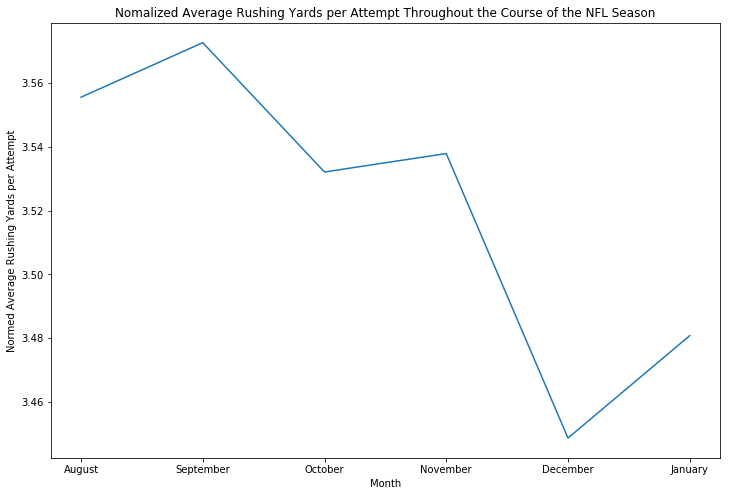

In [25]:
normed_rypa = []
for name in rb_df.player_name:
    normed_rypa.append(rb_df.rushing_yards_per_attempt[rb_df.player_name == name].mean())
rb_df['normed_rushing_YPA'] = normed_rypa
rypa = []
for m in rb_df.month.unique():
    rypa.append(rb_df.normed_rushing_YPA[rb_df.month == m].mean())

plt.figure(figsize=(12,8))
plt.plot(list(range(1,7)), rypa)
plt.xlabel('Month')
plt.ylabel('Normed Average Rushing Yards per Attempt')
plt.title('Nomalized Average Rushing Yards per Attempt Throughout the Course of the NFL Season')
plt.xticks(list(range(1,7)), month_names)
plt.show()

Adjusting the rushing yards per attempt, there is a slight difference in rushing yards per attempt throughout the season, but not all that much of a difference. It would seem that in actuality, rushing yards per attempt steadily decreases throughout the season (though not by much, honestly a 3.56 yard average is not much different from a 3.46 average). 

Let's look at rushing attempts now, to see if coaches are more prone to giving running backs more or less attempts throughout the season.

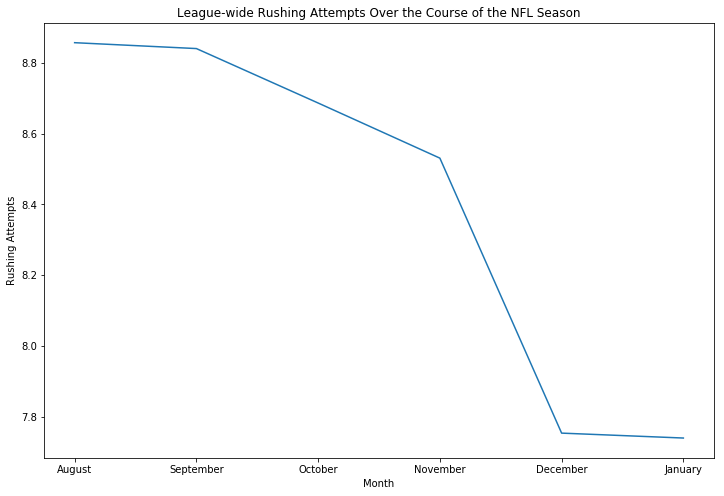

In [26]:
normed_attempts = []
for name in rb_df.player_name:
    normed_attempts.append(rb_df.rushing_attempts[rb_df.player_name == name].mean())
rb_df['normed_attempts'] = normed_attempts

rushing_attempt_average = []
for m in rb_df.month.unique():
    rushing_attempt_average.append(rb_df.normed_attempts[rb_df.month == m].mean())

plt.figure(figsize=(12,8))
plt.plot(list(range(1,7)), rushing_attempt_average)
plt.xlabel('Month')
plt.ylabel('Rushing Attempts')
plt.title('League-wide Rushing Attempts Over the Course of the NFL Season')
plt.xticks(list(range(1,7)), month_names)
plt.show()

There is actually a fairly significant number more attempts given to running back in August as opposed to the rest of the season, with a low and significant dropoff occurring in December.